# Toxic Comment Classification

This notebook analyzes toxic comments using NLP techniques.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize global variables
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Loading and Exploration

In [2]:
# Load dataset
df = pd.read_csv("/kaggle/input/nlp-big/train.csv")
df = df.head(1000)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Check missing values
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (1000, 8)

First few rows:
                 id                                      feedback_text  toxic  \
0  281d77b7bebc2201  :::Sounds good.  Let me know when you're done ...      0   
1  716aac7bf3c63db1  "\nI say something, but it didn't actually con...      0   
2  57cb318c6edcf10c  "Agustina Barrientos]] \n | Modelo de Piñeiro ...      0   
3  dc3bd70118d91b3a  FYI I enjoy licking strangers scrotal sacks......      1   
4  cf10d41f2997d233  How do you get a site?\nMany penguins have ask...      0   

   abusive  vulgar  menace  offense  bigotry  
0        0       0       0        0        0  
1        0       0       0        0        0  
2        0       0       0        0        0  
3        0       1       0        0        0  
4        0       0       0        0        0  

Missing Values:
 id               0
feedback_text    0
toxic            0
abusive          0
vulgar           0
menace           0
offense          0
bigotry          0
dtype: int64


## Data Visualization

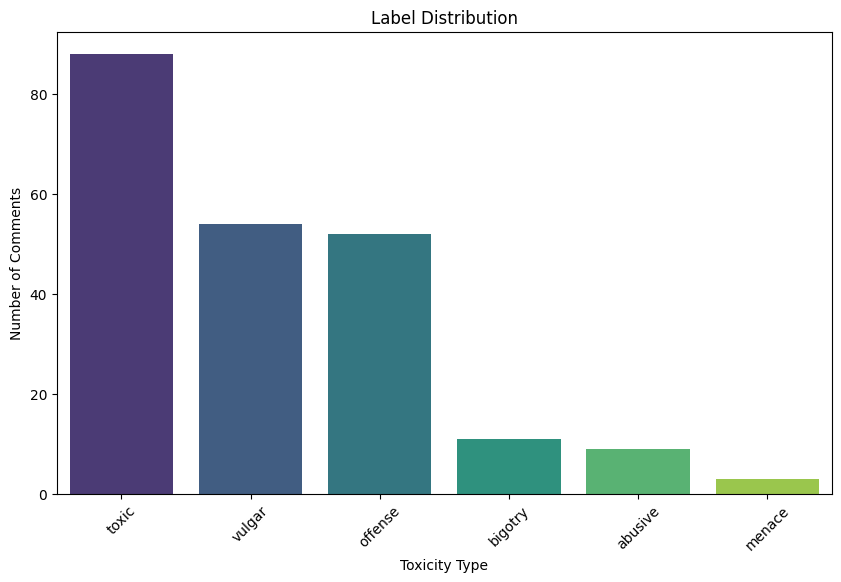

In [3]:
# Visualize label distribution
label_cols = [col for col in df.columns if col not in ['id', 'feedback_text']]
label_counts = df[label_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Label Distribution")
plt.ylabel("Number of Comments")
plt.xlabel("Toxicity Type")
plt.xticks(rotation=45)
plt.show()

## Text Preprocessing

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

slang_dict = {
    "u": "you",
    "ur": "your", 
    "r": "are",
    "pls": "please",
    "thx": "thanks",
    "idk": "i do not know",
    "wtf": "what the heck",
    "omg": "oh my god"
}

def clean_html(text):
    return re.sub(r'<.*?>', '', text)

def correct_spelling(text):
    return str(TextBlob(text).correct())

def convert_slang(text):
    words = text.split()
    return ' '.join([slang_dict.get(word.lower(), word) for word in words])

def remove_special_characters(text):
    # Remove special characters and numbers, keep only letters and spaces
    return re.sub(r'[^a-zA-Z\s]', '', text)

def preprocess_text(text, apply_spellcheck=False):
    if pd.isnull(text):
        return ""
    
    # Basic cleaning
    text = clean_html(text)
    text = text.lower()
    text = remove_special_characters(text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = convert_slang(text)
    
    if apply_spellcheck:
        text = correct_spelling(text)

    # Tokenize and lemmatize
    tokens = nltk.word_tokenize(text)
    
    # Remove stop words and short words, then lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens 
             if word not in stop_words 
             and len(word) > 2]
    
    return ' '.join(tokens)

# Apply preprocessing to text with progress bar
print("Preprocessing comments...")
tqdm.pandas(desc="Processing")  # Enable tqdm for pandas operations
df['processed_text'] = df['feedback_text'].progress_apply(lambda x: preprocess_text(x, apply_spellcheck=True))
print("Done preprocessing")

Preprocessing comments...


Processing: 100%|██████████| 1000/1000 [19:43<00:00,  1.18s/it] 

Done preprocessing


## Word2Vec Model Training

In [11]:
# Prepare texts for Word2Vec
tokenized_texts = [text.split() for text in df['processed_text']]

# Train Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,  # embedding size
    window=5,
    min_count=2,
    workers=4,
    sg=1  # 1 for skip-gram, 0 for CBOW
)

def get_average_word2vec(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

# Convert texts to vectors
X = np.array([get_average_word2vec(tokens, w2v_model, w2v_model.vector_size) 
              for tokens in tokenized_texts])

## Model Training and Evaluation

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Prepare target variable (toxic label)
y = df['toxic'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# Create grid search
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Perform grid search
print("Performing grid search...")
grid_search.fit(X_train, y_train)

# Get the best model
clf = grid_search.best_estimator_

# Print best parameters
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Make predictions with the best model
y_pred = clf.predict(X_test)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Performing grid search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 


Best Parameters: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.92125

Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       176
           1       0.00      0.00      0.00        24

    accuracy                           0.88       200
   macro avg       0.44      0.50      0.47       200
weighted avg       0.77      0.88      0.82       200



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-package

## Model Evaluation

In [21]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.3f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Recall: {:.3f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('F1-score: {:.3f}'.format(f1_score(y_test, y_pred, average='weighted')))

# Get probability predictions for ROC curve
y_pred_proba = clf.predict_proba(X_test)[:,1]

Accuracy: 0.880
Precision: 0.774
Recall: 0.880
F1-score: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


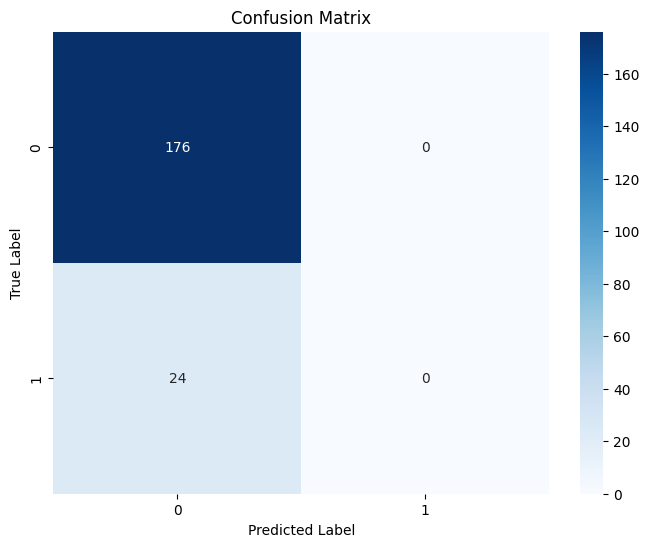

In [24]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

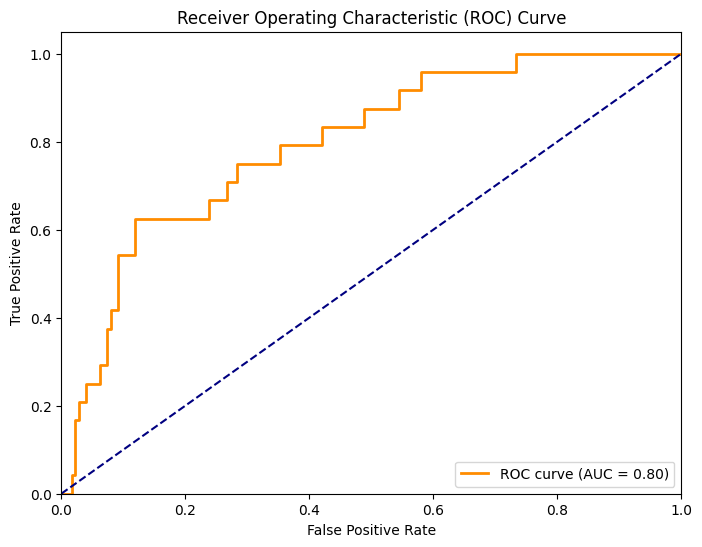

In [25]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The evaluation metrics show how well our model performs at classifying toxic comments:

- Accuracy measures the overall correct predictions
- Precision indicates how many of the predicted toxic comments were actually toxic
- Recall shows what fraction of actual toxic comments were correctly identified
- F1-score is the harmonic mean of precision and recall

The confusion matrix visualizes the true positives, false positives, true negatives and false negatives.

The ROC curve plots the true positive rate against false positive rate at various thresholds, with the AUC (Area Under Curve) score indicating overall classification performance.

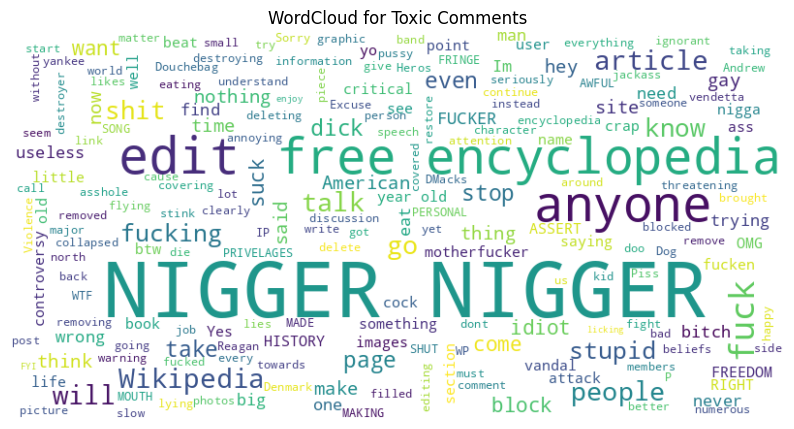

In [26]:
# Step 3: Generate a WordCloud for toxic comments
toxic_comments = df[df['toxic'] == 1]['feedback_text']
toxic_text = ' '.join(toxic_comments)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(toxic_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Toxic Comments')
plt.show()